In [16]:
import re
import numpy as np
import itertools
import time
import linecache as lc
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
def read_file(filename):
    with open(filename, 'r') as file:
        content = file.read()  # Open the file in read mode

    data = {}  # Initialize data as an empty dictionary

    # Each file has number of inputs under which data is stored as a matrix
    numerical_data = re.findall(r'\[([\d\s.]+)\]', content)  # Extract values following each header as numerical values and remove '\t's and '\n's

    sections = ['Orders', 'Allocations', 'DistanceShelfShelf', 'DistancePackagingShelf', 'FullDistanceMatrixMetres']

    for i, section in enumerate(sections):
        data[section] = []
        lines = numerical_data[i].strip().split('\n')
        for line in lines:
            values = line.strip().split()  # Split using spaces
            data[section].append([int(val) for val in values])  # Assuming all values are integers

    return data

def allocation_from_txt(file):
    allocation_vector = lc.getline(file, 1).split(" ")[:-1]
    allocation_vector = [int(prod) for prod in allocation_vector]
    return np.array(allocation_vector)

In [3]:
filename = r"Xpress_Data_Files/Data_Xpress_FullDist_Metres.txt"
data = read_file(filename)

# Extracting data into arrays
Orders = data.get('Orders')
Allocations = np.asarray(data.get('Allocations')[0])
DistanceShelfShelf = np.asarray(data.get('DistanceShelfShelf'))
FullDistanceMatrix = np.asarray(data.get('FullDistanceMatrixMetres'))

NbShelves = 96
Shelves = range(1, NbShelves + 1)

FullDistanceMatrix = np.roll(FullDistanceMatrix, shift = 1, axis = 1)
FullDistanceMatrix = np.roll(FullDistanceMatrix, shift = 1, axis = 0)


# testing for allocation vector where every shelf is filled
allocations_full = [45, 79, 39, 68, 73, 53, 19, 44, 16, 71, 27, 41,  2, 46, 60, 67, 56, 
                    83, 80, 57, 69, 55, 75, 34, 89, 12, 81, 62, 23, 26, 24, 86,  3, 17,
                    90, 58, 51, 25, 85, 65, 31, 11, 87, 10, 13, 70, 35, 32, 47,  6, 30,
                    21, 43, 64, 66, 78, 76, 61,  8, 72, 22, 18, 82, 14, 28,  4,  5, 84,
                    54, 48, 63, 29, 49, 74, 37, 36, 20, 38, 50,  7, 88,  9, 40, 77, 15,
                    1, 33, 59, 42, 52,  45, 79, 39, 68, 73, 53]


# testing where only some of the extra shelves are filled
allocations_mid_full = [45, 79, 39, 68, 73, 53, 19, 44, 16, 71, 27, 41,  2, 46, 60, 67, 56, 
                        83, 80, 57, 69, 55, 75, 34, 89, 12, 81, 62, 23, 26, 24, 86,  3, 17,
                        90, 58, 51, 25, 85, 65, 31, 11, 87, 10, 13, 70, 35, 32, 47,  6, 30,
                        21, 43, 64, 66, 78, 76, 61,  8, 72, 22, 18, 82, 14, 28,  4,  5, 84,
                        54, 48, 63, 29, 49, 74, 37, 36, 20, 38, 50,  7, 88,  9, 40, 77, 15,
                        1, 33, 59, 42, 52,  45, 79,  0, 68,  0, 53]


In [4]:
def find_closest_product(current_shelf, order, distances):
    closest_shelf = None
    min_distance = float(1e6)
    for shelf in order:
        if distances[current_shelf][shelf] <= min_distance:
            closest_shelf = shelf
            min_distance = distances[current_shelf][shelf]
    return closest_shelf

def generate_order_lists(order):
    ''' 
    Takes a list with tuple elements and returns a list of lists 
    with all possible combinations of individual elements individual elements.
    '''
    order_lists = []
    tuple_indices = [i for i, item in enumerate(order) if isinstance(item, tuple)]
    for combination in itertools.product(*[order[i] for i in tuple_indices]):
        new_order = order.copy()
        for i, index in enumerate(tuple_indices):
            new_order[index] = combination[i]
        order_lists.append(new_order)
    return order_lists

def greedy_order_route(order, distances):
    ''' 
    Uses a greedy method of calculating the minimum distance. 

    Function has been split into two if statements to consider
    cases of orders where products are contained on more than one shelf.

    If products are contained on more than one shelf, the function constructs 
    a route with all possible shelf combinations and chooses the one with 
    the shortest distance.

    Returns a list containing the route and the total distance for the order.
    '''

    # If all products in the order are contained on one shelf only
    if not any(isinstance(product, tuple) for product in order):
        visited = [0]
        current_position = 0  
        for k in range(len(order)):
                closest_product = find_closest_product(current_position, order, distances)
                visited.append(closest_product)
                order.remove(closest_product)
                current_position = closest_product
        visited.append(0)
        OrderDistance = 0
        for i in range(len(visited) - 1):
            OrderDistance += distances[visited[i]][visited[i+1]]
        order_distance_final = OrderDistance
        visited_final = visited

    # If one or more products in the order are contained on more than one shelf
    elif any(isinstance(product, tuple) for product in order):
        order_combinations = generate_order_lists(order) # create new orders with all possible combinations from tuples
        order_routes = []   # initialise a list of routes for all combinations                                 
        order_distances = [] # initialise a list of distances for all combinations
        
        # loop over all combinations
        for order in order_combinations:
            visited = [0]
            current_position = 0  
            for k in range(len(order)):
                closest_product = find_closest_product(current_position, order, distances)
                visited.append(closest_product)
                order.remove(closest_product)
                current_position = closest_product
            visited.append(0)
            order_routes.append(visited) # add the route for the combination to the list of routes
            OrderDistance = 0
            for i in range(len(visited) - 1):
                OrderDistance += distances[visited[i]][visited[i+1]]
            order_distances.append(OrderDistance) # add the distance for the combination to the list of distances
        
        # select the order with the shortest distance among the combinations
        min_idx = order_distances.index(min(order_distances))
        visited_final = order_routes[min_idx] 
        order_distance_final = order_distances[min_idx]
            
    return visited_final, order_distance_final # return order route and distance

def convert_orders_to_shelf_indices(allocations):
    ''' 
    This function takes the allocation vector and returns an 
    order matrix with shelf indices instead of product indices.
    '''
    product_to_shelf = {}
    for shelf_index, product in enumerate(allocations):
        if product != 0:  # Check if the element is not zero
            if product not in product_to_shelf:
                product_to_shelf[product] = [shelf_index + 1]  # Initialize with a list containing the current shelf index
            else:
                # If the product already exists in the dictionary, append the new shelf index to the list
                product_to_shelf[product].append(shelf_index + 1)

    # Convert product_to_shelf dictionary to a list of tuples if the product is assigned to multiple shelves
    product_to_shelf_tuples = {k: tuple(v) if len(v) > 1 else v[0] for k, v in product_to_shelf.items()}

    OrdersByShelf = []
    for order in Orders:
        order_shelf_indices = []
        for product_index in order:
            if product_index in product_to_shelf_tuples:
                shelf_indices = product_to_shelf_tuples[product_index]
                order_shelf_indices.append(shelf_indices)
            else:
                order_shelf_indices.append(0)  # Product not found in allocation matrix
        OrdersByShelf.append(order_shelf_indices)

    return OrdersByShelf

def q1_function(allocation_vector, distance_matrix):

    OrdersByShelf = convert_orders_to_shelf_indices(allocation_vector)
    TotalDistance = 0           # initialise counter for total distance
    DistancesPerOrder = []      # initalise list to contain the distances for each order 
    routes = []                 # intialise list to contain the routes for each order
    for order in OrdersByShelf:
        visited_order_route, visited_order_dist = greedy_order_route(order, distance_matrix)
        routes.append(visited_order_route)
        DistancesPerOrder.append(visited_order_dist)
        TotalDistance += visited_order_dist

    # Replace DistancesPerOrder in the return statement with this if you want sorted distances to be returned
    SortedDistancesPerOrder = sorted(DistancesPerOrder, reverse=True)

    # The indices corresponding to the longest orders (descending order) 
    idx_longest_orders = sorted(range(len(DistancesPerOrder)), key=lambda i: DistancesPerOrder[i], reverse=True)

    # List of routes ordered by distance (descending)
    OrderedRoutes = [routes[i] for i in idx_longest_orders]
    
    return TotalDistance, DistancesPerOrder, SortedDistancesPerOrder, idx_longest_orders, OrderedRoutes

In [5]:
print(Allocations)

[45 79 39 68 73 53 19 44 16 71 27 41  2 46 60 67 56 83 80 57 69 55 75 34
 89 12 81 62 23 26 24 86  3 17 90 58 51 25 85 65 31 11 87 10 13 70 35 32
 47  6 30 21 43 64 66 78 76 61  8 72 22 18 82 14 28  4  5 84 54 48 63 29
 49 74 37 36 20 38 50  7 88  9 40 77 15  1 33 59 42 52  0  0  0  0  0  0]


In [11]:
decreases = []
products = [x for x in range(1, 91)]

for i in range(10):
    temp = []
    tempAllocations = Allocations.copy()
    tempProducts = products.copy()

    temp.append(q1_function(tempAllocations, FullDistanceMatrix)[0])

    for i in range(6):
        nextitem = random.choice(tempProducts)
        tempAllocations[90+i] = nextitem
        tempProducts.remove(nextitem)
        temp.append(q1_function(tempAllocations, FullDistanceMatrix)[0])

    print(temp)
    decreases.append(temp)










[290706, 290352, 289974, 289860, 289794, 289662, 289662]
[290706, 290256, 289752, 289752, 289698, 289698, 289356]
[290706, 289812, 289782, 289752, 289614, 289614, 289614]
[290706, 289332, 289278, 289230, 289032, 288564, 288462]
[290706, 290292, 289686, 289668, 289590, 289482, 289440]
[290706, 290352, 289548, 289362, 288372, 288282, 288252]
[290706, 290664, 290490, 290490, 290460, 290370, 290370]
[290706, 290046, 289896, 289782, 289644, 289608, 289554]
[290706, 290388, 290250, 290166, 289698, 289350, 289350]
[290706, 290598, 290520, 289968, 289806, 289734, 289734]


In [10]:
print(decreases)

[[290706, 290190, 290028, 290028, 289902, 289590], [290706, 290706, 290382, 290382, 290292, 289506], [290706, 290502, 290502, 290358, 290214, 290214], [290706, 290136, 289812, 288702, 288672, 288636], [290706, 290400, 290196, 290196, 290154, 289992], [290706, 290502, 290430, 290274, 290064, 290028], [290706, 290706, 290028, 289968, 288996, 288714], [290706, 290592, 290406, 290142, 288732, 288378], [290706, 290592, 290454, 290184, 289242, 289188], [290706, 290388, 290202, 290088, 289698, 289584]]


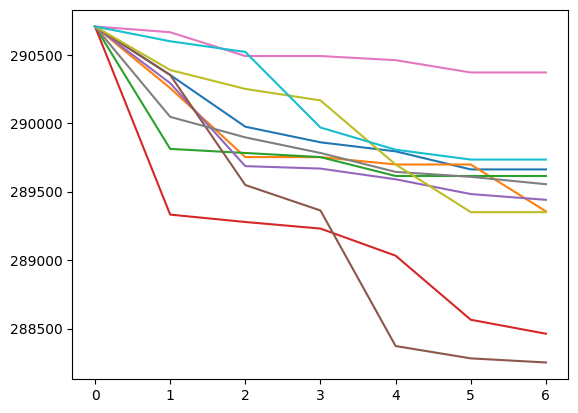

In [17]:


for temp in decreases:
    plt.plot([0,1,2,3,4,5,6], temp)